In [439]:
from libs import *

import numpy as np
import copy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# # Define os parâmetros do problema
num_clients = 495
num_pa_locations = 30
pa_capacity = 54  # Capacidade de cada PA
pa_coverage = 85  # Raio de cobertura de cada PA
pa_exposure = 1  # Exposição nominal do PA
exposure_coefficient = 1  # Coeficiente de exposição

In [440]:
def update_solution(new_solution):
   return copy.deepcopy(new_solution)

def round_to_nearest_5(x):
    return 5 * np.round(x / 5)

# Carrega os dados dos clientes do arquivo CSV
def get_clients():
  clients = np.genfromtxt('clientes.csv', delimiter=',')
  return clients


def kmeans(solution, num_pas=None):

  num_pas = np.sum(solution['y'])
  coord_kmeans= pd.DataFrame(solution['client_coordinates'], columns=['x', 'y'])

  if num_pas < num_pa_locations:
    
    num_pas += 1

    # Normalizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(coord_kmeans)

    # Aplicar K-means para formar os clusters
    kmeans = KMeans(n_clusters=int(num_pas), random_state=0)
    clusters = kmeans.fit_predict(X_scaled)
  
    solution['pa_coordinates'] = kmeans.cluster_centers_

    solution['pa_coordinates'] = scaler.inverse_transform(solution['pa_coordinates']) # Reverter a normalização para obter as coordenadas originais   

    solution['pa_coordinates'] = round_to_nearest_5(solution['pa_coordinates'])

    for i in range(num_pa_locations):
      if i < num_pas:
          solution['y'][i] = 1
      else:
          solution['y'][i] = 0
    
    return solution
  
  print("Numero de PAs Exedido")

  return

    

      
    


In [441]:
def client_active_check(solution):
    
    client_coordinates = solution['client_coordinates']
    active_pa_coordinates = []
    active_pa_indices = []

    # Coletar coordenadas dos PAs ativos e seus índices originais
    for i in range(num_pa_locations):
        if solution['y'][i] == 1:
            active_pa_coordinates.append(solution['pa_coordinates'][i])
            active_pa_indices.append(i)        
        if solution['y'][i] == 0:
           solution['x'][i] = np.zeros(num_clients)

    # Convertendo a lista para um array numpy para cálculos de distância
    active_pa_coordinates = np.array(active_pa_coordinates)

    # Verificar se há PAs ativos
    if len(active_pa_coordinates) == 0:
        print("Nenhum PA ativo.")
        return

    # Atribuir cada cliente ao PA ativo mais próximo
    for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distances_to_pas = np.sqrt(np.sum((active_pa_coordinates - np.array([client_x, client_y]))**2, axis=1))
        closest_pa_index = np.argmin(distances_to_pas)
        original_pa_index = active_pa_indices[closest_pa_index]        

        if distances_to_pas[closest_pa_index] > pa_coverage:         
            distances_to_pas = np.delete(distances_to_pas, closest_pa_index)   
            closest_pa_index = np.argmin(distances_to_pas)
            original_pa_index = active_pa_indices[closest_pa_index]

        solution['x'][original_pa_index, j] = 1
        


In [442]:
def initial_solution(clients_data, solution):

    # Extrai as coordenadas dos clientes do array
    client_coordinates = clients_data[:, :2]
    solution['client_coordinates'] = client_coordinates

    # Extrai a largura de banda dos clientes do array
    solution['client_bandwidth'] = clients_data[:, 2]

    # Verifica o numero minimo de PAs necessários para atender todos os clientes
    pa_min = round(np.sum(solution['client_bandwidth']) / pa_capacity)
    
    coord_kmeans= pd.DataFrame(solution['client_coordinates'], columns=['x', 'y'])
   
    # Normalizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(coord_kmeans)

    # Aplicar K-means para formar os clusters
    kmeans = KMeans(n_clusters=pa_min, random_state=0)
    clusters = kmeans.fit_predict(X_scaled)
   
    solution['pa_coordinates'] = kmeans.cluster_centers_

    solution['pa_coordinates'] = scaler.inverse_transform(solution['pa_coordinates']) # Reverter a normalização para obter as coordenadas originais   

    solution['pa_coordinates'] = round_to_nearest_5(solution['pa_coordinates'])

    # Gerar coordenadas aleatorias para os outros PAs com resolução de 5 metros
    pa_coordinates = np.random.randint(0, 80, size=((num_pa_locations - pa_min), 2)) * 5  # 80 é o tamanho do grid

    # Adicionar as coordenadas aleatórias com as dos centroides do k-means aos PAs  
    solution['pa_coordinates'] = np.vstack((solution['pa_coordinates'],pa_coordinates))
    pa_coordinates = solution['pa_coordinates']

    # Ativa todos os PAs gerados pelo k-means
    # Coletar coordenadas dos PAs ativos e seus índices originais
    for i in range(num_pa_locations):
        if i < pa_min:
            solution['y'][i] = 1
        else:
            solution['y'][i] = 0

    # Calcula a distancia entre cada cliente e cada PA
    for i in range(num_pa_locations):
      pa_x, pa_y = solution['pa_coordinates'][i]
      for j in range(num_clients):
          client_x, client_y = client_coordinates[j]
          distance = np.sqrt((pa_x - client_x) ** 2 + (pa_y - client_y) ** 2)
          solution['client_pa_distances'][i, j] = distance

    # Calcula a distancia entre todos os PAs
    for i in range(num_pa_locations):
      pa_x, pa_y = pa_coordinates[i]
      for j in range(num_pa_locations):
        paj_x, paj_y = pa_coordinates[j]
        distance = np.sqrt((pa_x - paj_x) ** 2 + (pa_y - paj_y) ** 2)
        solution['pas_distances'][i, j] = distance
   
    # Atribuir cada cliente ao PA mais próximo
    for j in range(num_clients):
        pa_distance = []
        for i in range(pa_min):          
            pa_distance.append(solution['client_pa_distances'][i,j])
            closest_pa_index = np.argmin(pa_distance)   
        solution['x'][closest_pa_index, j] = 1

    return solution


# Função para gerar uma solução qualquer
def generate_solution(clients_data, constructor_heuristic=True):
    # Inicialize as variáveis de decisão
    solution = {
        'x': np.zeros((num_pa_locations, num_clients)),  # Variáveis de decisão para atribuição de clientes a PAs
        'y': np.zeros(num_pa_locations),  # Variáveis de decisão para ativação de PAs
        'client_coordinates': np.zeros((num_clients, num_clients)),  # Armazena as posições (x,y) de cada cliente
        'client_pa_distances': np.zeros((num_pa_locations, num_clients)),  # Armazena a distancia entre cliente e PA
        'client_bandwidth': np.zeros(num_clients), # Armazena a largura de banda necessária de cada cliente
        'penalty': np.zeros(0), # Armazena a penalidade da solução
        'fitness': np.zeros(0), # Armazena o ajuste da solução
        'penalty_fitness': np.zeros(0), # Armazena o ajuste somado a penalidade da solução
        'pas_distances': np.zeros((num_pa_locations, num_pa_locations))
    }

    if constructor_heuristic:
      return initial_solution(clients_data, solution)
    
    # Extrai as coordenadas dos clientes do array
    client_coordinates = clients_data[:, :2]
    solution['client_coordinates'] = client_coordinates

    # Extrai a largura de banda dos clientes do array
    solution['client_bandwidth'] = clients_data[:, 2]

    # Gerar coordenadas aleatorias para os PAs com resolução de 5 metros
    #HEURÍSTICA A SER ALTERADA
    pa_coordinates = np.random.randint(0, 80, size=(num_pa_locations, 2)) * 5  # 80 é o tamanho do grid
    solution['pa_coordinates'] = pa_coordinates

    # Ativa aleatoriamente um número máximo de PAs
    num_active_pas = np.random.randint(1, num_pa_locations + 1)
    active_pas_indices = np.random.choice(num_pa_locations, num_active_pas, replace=False)
    solution['y'][active_pas_indices] = 1

    # Atribui cada cliente a um PA aleatoriamente e deixa ativo
    for j in range(num_clients):
        i = np.random.randint(num_pa_locations)  # Seleciona um PA aleatório
        solution['x'][i, j] = 1  # Atribui o cliente j ao PA i

    # Calcula a distancia entre cada cliente e cada PA ativo
    for i in range(num_pa_locations):
      pa_x, pa_y = pa_coordinates[i]
      for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distance = np.sqrt((pa_x - client_x) ** 2 + (pa_y - client_y) ** 2)
        solution['client_pa_distances'][i, j] = distance

    return solution

In [443]:
# Restrições
def constraint_min_clients_served(solution):
    # Restrição R1: Garantir que o percentual mínimo de clientes seja atendido
    return np.sum(solution['x']) >= (0.98 * num_clients)

def constraint_capacity(solution):
    # Restrição R2: Garantir que a capacidade dos PAs ativos não seja violada
    for i in range(num_pa_locations):
        if solution['y'][i] == 1: 
            for j in range(num_clients):
                if solution['client_bandwidth'][j] > pa_capacity:
                    return False
    return True

def constraint_coverage(solution):
    # Restrição R3: Garantir que PAs ativos só atendam clientes que estejam dentro do seu raio de cobertura
    for i in range(num_pa_locations):
        if solution['y'][i] == 1: 
            for j in range(num_clients):
                if solution['x'][i, j] == 1:
                    if solution['client_pa_distances'][i,j] > pa_coverage:
                        #print("cliente ", j," longe do PA ",i," distancia de ",solution['client_pa_distances'][i,j]," metros")
                        return False
    return True

def constraint_exposure(solution):
    # Restrição R4: Garantir que exposição acumulada de cada cliente à rede de PAs ativos seja no mínimo 5% do coeficiente de exposição
    
    pa_cover = pa_exposure * np.sum(solution['y'])
    
    for j in range(num_clients):
        client_cover = 0
        for i in range(num_pa_locations):
            if solution['y'][i] == 1:
                if solution['client_pa_distances'][i, j] != 0:
                    client_cover += pa_cover / solution['client_pa_distances'][i, j]
        if client_cover < 0.05 * exposure_coefficient:
            return False
    return True

def constraint_unique_assignment(solution):
    # Restrição R5: Garantir que cada cliente seja atribuído a no máximo um PA
    return np.all(np.sum(solution['x'], axis=0) <= 1)

def constraint_max_pas(solution):
    # Restrição R6: Garantir que o número máximo de PAs ativos não seja violado
    return np.sum(solution['y']) <= num_pa_locations

def constraint_binary_variables(solution):
    # Restrições R7 e R8: Definir o domínio das variáveis de otimização do problema
    return np.all(np.logical_or(solution['x'] == 0, solution['x'] == 1)) and np.all(np.logical_or(solution['y'] == 0, solution['y'] == 1))

def constraint_pa_coordinates(solution):
    # Restrição R9: Garantir que as coordenadas dos pontos de acesso sejam múltiplos de 5
    pa_coordinates = solution['pa_coordinates']
    return np.all(pa_coordinates % 5 == 0)

In [444]:
constraints = [constraint_min_clients_served, constraint_capacity, constraint_coverage, constraint_exposure, constraint_unique_assignment, constraint_max_pas, constraint_binary_variables, constraint_pa_coordinates]

In [445]:
constraints_name = ['constraint_min_clients_served', 'constraint_capacity', 'constraint_coverage', 'constraint_exposure', 'constraint_unique_assignment', 'constraint_max_pas', 'constraint_binary_variables', 'constraint_pa_coordinates']

def penalty_method(solution, constraints):

  # Aplicar as penalidades para as violações de restrições
    penalty = 0
    iterador = 0
    for constraint in constraints:
      if not constraint(solution):
          penalty += 100
          #print(constraints_name[iterador])

      iterador += 1

   # print('\n')

    return penalty

In [446]:
# Função objetivo 1: Minimizar a quantidade de PAs ativos
def objective_function_1(solution, constraints):

    solution['fitness'] = 0
    solution['penalty'] = 0
    solution['penalty_fitness'] = 0

    # Calculo da função objetivo
    solution['fitness'] = np.sum(solution['y'])

    # Calculo das penalidades
    solution['penalty'] = penalty_method(solution, constraints)

    # Aplicação das penalidades
    solution['penalty_fitness'] = solution['penalty'] + solution['fitness']

    return solution

# Função objetivo 2: Minimizar a soma total das distâncias entre os PAs ativos e clientes atendidos
def objective_function_2(solution, constraints):

    solution['fitness'] = 0
    solution['penalty'] = 0
    solution['penalty_fitness'] = 0

    # Calculo da função objetivo
    solution['fitness'] = np.sum(np.multiply(solution['client_pa_distances'], solution['x']))

    # Calculo das penalidades
    solution['penalty'] = penalty_method(solution, constraints)

    # Aplicação das penalidades
    solution['penalty_fitness'] = solution['penalty'] + solution['fitness']

    return solution


In [447]:
# certifica que todos os clientes estão vincluados a um PA ativo

def feasibility(nova, old = None):

    solution = update_solution(nova)
    previous_solution = update_solution(old)

    clients = np.sum(solution['x'])
    
    if clients < (0.98 * num_clients) or clients > num_clients or (lambda i,j: (solution['client_pa_distances'][i,j] > 85) for i in range(num_pa_locations) for j in range(num_clients)):        
        client_active_check(solution)  
    
    solution = objective_function_1(solution, constraints)
    
    if solution['fitness'] >=  previous_solution['fitness'] and solution['penalty_fitness'] > previous_solution['penalty_fitness']:
        return previous_solution
    
    return solution
    
    


In [448]:
# Estruturas de Vizinhança
def swap_clients_between_pas(solution):
    # Troca de Clientes entre PAs (Swap)
    new_solution = update_solution(solution)  # Criar uma cópia da solução atual
    old_solution = update_solution(solution) # Criar uma cópia da solução atual

    active_pas = np.sum(new_solution['y'])

    client_coordinates = new_solution['client_coordinates']
    active_pa_coordinates = []
    active_pa_indices = []

    # Coletar coordenadas dos PAs ativos e seus índices originais
    for i in range(num_pa_locations):
        if solution['y'][i] == 1:
            active_pa_coordinates.append(solution['pa_coordinates'][i])
            active_pa_indices.append(i)        
        if solution['y'][i] == 0:
           solution['x'][i] = np.zeros(num_clients)



    # Atribuir cada cliente ao PA ativo mais próximo
    for j in range(num_clients):
        client_x, client_y = client_coordinates[j]
        distances_to_pas = np.sqrt(np.sum((active_pa_coordinates - np.array([client_x, client_y]))**2, axis=1))
        closest_pa_index = np.argmin(distances_to_pas)
        original_pa_index = active_pa_indices[closest_pa_index]        

        if distances_to_pas[closest_pa_index] > pa_coverage:         
            distances_to_pas = np.delete(distances_to_pas, closest_pa_index)   
            closest_pa_index = np.argmin(distances_to_pas)
            original_pa_index = active_pa_indices[closest_pa_index]

        solution['x'][original_pa_index, j] = 1


       

    # Selecionar aleatoriamente dois PAs ativos diferentes    
    pa_indices = np.random.choice(np.arange(active_pas.astype(int)), size=2, replace=False)
    pa1_index, pa2_index = pa_indices

    # Selecionar aleatoriamente um cliente atribuído ao PA1 e outro ao PA2
    client_indices_pa1 = np.where(new_solution['x'][pa1_index] == 1)[0]
    client_indices_pa2 = np.where(new_solution['x'][pa2_index] == 1)[0]

    if len(client_indices_pa1) > 0 and len(client_indices_pa2) > 0:
        client_index_pa1 = np.random.choice(client_indices_pa1)
        client_index_pa2 = np.random.choice(client_indices_pa2)

        # Realizar a troca dos clientes entre os PAs
        new_solution['x'][pa1_index, client_index_pa1] = 0
        new_solution['x'][pa2_index, client_index_pa2] = 0
        new_solution['x'][pa1_index, client_index_pa2] = 1
        new_solution['x'][pa2_index, client_index_pa1] = 1

    new_solution = feasibility(new_solution, old_solution)

    return new_solution

def add_or_remove_pas(solution):
    # Adição ou Remoção de PAs
    new_solution = update_solution(solution)  # Criar uma cópia da solução atual
    old_solution = update_solution(solution) # Criar uma cópia da solução atual

    # Selecionar aleatoriamente um número de PAs a adicionar ou remover
    num_pas_to_add_or_remove = np.random.randint(1, num_pa_locations + 1)

    # Selecionar aleatoriamente quais PAs adicionar ou remover
    pa_indices = np.random.choice(np.arange(num_pa_locations), size=num_pas_to_add_or_remove, replace=False)

    # Ativar ou desativar os PAs selecionados
    for pa_index in pa_indices:
        new_solution['y'][pa_index] = 1 - new_solution['y'][pa_index]
    
    new_solution = feasibility(new_solution, old_solution)

    return new_solution

def shift_pa_positions(solution):
    # Movimento dos PAs (Shift)
    new_solution = update_solution(solution)  # Criar uma cópia da solução atual
    old_solution = update_solution(solution) # Criar uma cópia da solução atual

    # MUDAR GERAÇÃO DE NOVA POSIÇÃO
    # Gerar uma nova posição para cada PA

    client_coordinates = new_solution['client_coordinates']
    pa_coordinates = new_solution['pa_coordinates']

                   


    #active_pas = np.sum(new_solution['y'])
    
    
    #pa_sobra = int((active_pas - num_pa_locations) / active_pas)
    #if ((active_pas - num_pa_locations) % active_pas) > 0: 
    #    pa_extra = ((active_pas - num_pa_locations) % active_pas)


    print(pa_coordinates)
    

      


    #new_pa_coordinates = np.random.randint(0, 80, size=(num_pa_locations, 2)) * 5  # 80 é o tamanho do grid em metros

    # Atualizar as coordenadas dos PAs na solução
    new_solution['pa_coordinates'] = pa_coordinates

    # Recalcular as distâncias entre os clientes e os PAs com as novas posições
    for i in range(num_pa_locations):
        pa_x, pa_y = pa_coordinates[i]
        for j in range(num_clients):
            client_x, client_y = new_solution['client_coordinates'][j]
            distance = np.sqrt(((pa_x - client_x) + (pa_y - client_y))**2, axis=1)
            new_solution['client_pa_distances'][i, j] = distance

    new_solution = feasibility(new_solution, old_solution)

    return new_solution

def add_new_pa(solution):
    # Adição de um PA novo
    new_solution = update_solution(solution)  # Criar uma cópia da solução atual
    old_solution = update_solution(solution) # Criar uma cópia da solução atual

    new_solution = kmeans(new_solution)
        
    new_solution = feasibility(new_solution, old_solution)

    return new_solution


def neighborhood_change(solution, neighborhood):

  #print(type(solution['fitness']))

  match neighborhood:
    case 1:
      return add_new_pa(solution)
    #case 2:
    #  return swap_clients_between_pas(solution)
    #case 3:
      #return add_or_remove_pas(solution)
    #case 2:
      #print("ALGO ERRADO 4ª Vizinhaça")
      #return shift_pa_positions(solution)
    case _:
        return solution

In [449]:
def solution_check(new_solution, solution, neighborhood):

    nova = update_solution(new_solution)
    antiga = update_solution(solution)
    
    # Atualizar a melhor solução encontrada e altera a vizinhança se necessário
    if (nova['penalty'] < antiga['penalty']):
        neighborhood = 1
        return nova, neighborhood
    elif (nova['fitness'] < antiga['fitness'] and nova['penalty'] == antiga['penalty']):
        neighborhood = 1
        return nova, neighborhood
    else:
        neighborhood += 1
        return antiga, neighborhood

    

In [450]:
# Algoritmo para otimizar cada função objetivo individualmente
def bvns_method(objective_function, constraints, construct_heuristc=False, max_iter=100, neighborhood_max = 3):

    progress = {
        'fitness': np.zeros(max_iter),
        'penalty': np.zeros(max_iter),
        'penalty_fitness': np.zeros(max_iter)
    }

    # Atribui os dados dos clientes
    clients_data = get_clients()

    # Gerar uma solução aleatória viável
    solution = generate_solution(clients_data)
    solution = objective_function(solution, constraints)


    for i in range(max_iter):

      #print(f"iteração {i}:\n")
      neighborhood = 1

      progress['fitness'][i] = solution['fitness']
      progress['penalty'][i] = solution['penalty']
      
      while neighborhood <= neighborhood_max:

        solution = update_solution(solution)

        new_solution = neighborhood_change(solution, neighborhood)
        
        # Calcula a função objetivo da solução gerada        
        new_solution = objective_function(new_solution, constraints)

        # Compara o fitness da solução nova com a atual com as soluções da vizinhança
        solution, neighborhood = solution_check(new_solution, solution, neighborhood)


    print("\nFIM DE EXECUÇÃO\n")

    solution = update_solution(solution)

    print("SOLUÇÃO FINAL")
    print("FIT   : ", solution['fitness'])
    print("SOMA Y: ", np.sum(solution['y']))
    tot = 0
    for i in range(num_pa_locations):
       if solution['y'][i] == 1:
          tot += np.sum(solution['x'][i])
    
    print("TOTAL CLIENTES", np.sum(tot))

    print("\n----------------------------------------------------------\n")
    return solution, progress

In [451]:
# Chamar o algoritmo de Penalidade para otimizar cada função objetivo individualmente
# Para a função objetivo 1
result = []
progress = {}
best_solution = {}
for i in range(5):
    best_solution[i], progress[i] = bvns_method(objective_function_1, constraints)
    print("FITNESS: ", best_solution[i]['fitness'])
    print("PENALIDADE: ",best_solution[i]['penalty'])
    print("FIT+PEN: ",best_solution[i]['penalty_fitness'])
    result.append(best_solution[i]['penalty_fitness'])
    print("num PAs: ", i, np.sum(best_solution[i]['y']))
    #print("PAs coord: ", i, best_solution['pa_coordinates'])

print('\n--- MELHOR SOLUÇÃO de f1 ENCONTRADA ---\n')
print('O valor MIN encontrado foi:', np.min(result))
print('O valor STD encontrado foi:', np.std(result))
print('O valor MAX encontrado foi:', np.max(result))


FIM DE EXECUÇÃO

SOLUÇÃO FINAL
FIT   :  7.0
SOMA Y:  7.0
TOTAL CLIENTES 495.0

----------------------------------------------------------

FITNESS:  7.0
PENALIDADE:  100
FIT+PEN:  107.0
num PAs:  0 7.0

FIM DE EXECUÇÃO

SOLUÇÃO FINAL
FIT   :  7.0
SOMA Y:  7.0
TOTAL CLIENTES 495.0

----------------------------------------------------------

FITNESS:  7.0
PENALIDADE:  100
FIT+PEN:  107.0
num PAs:  1 7.0

FIM DE EXECUÇÃO

SOLUÇÃO FINAL
FIT   :  7.0
SOMA Y:  7.0
TOTAL CLIENTES 495.0

----------------------------------------------------------

FITNESS:  7.0
PENALIDADE:  100
FIT+PEN:  107.0
num PAs:  2 7.0

FIM DE EXECUÇÃO

SOLUÇÃO FINAL
FIT   :  7.0
SOMA Y:  7.0
TOTAL CLIENTES 495.0

----------------------------------------------------------

FITNESS:  7.0
PENALIDADE:  100
FIT+PEN:  107.0
num PAs:  3 7.0

FIM DE EXECUÇÃO

SOLUÇÃO FINAL
FIT   :  7.0
SOMA Y:  7.0
TOTAL CLIENTES 495.0

----------------------------------------------------------

FITNESS:  7.0
PENALIDADE:  100
FIT+PEN:  107.0
n

CLIENTES CONECTADOS 495.0
CLIENTES SEM CONEXÃO 0.0


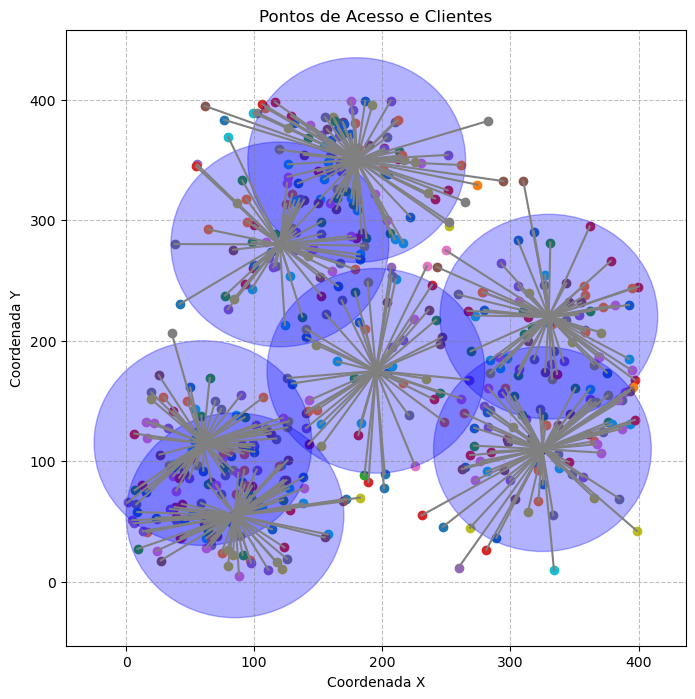

CLIENTES CONECTADOS 495.0
CLIENTES SEM CONEXÃO 0.0


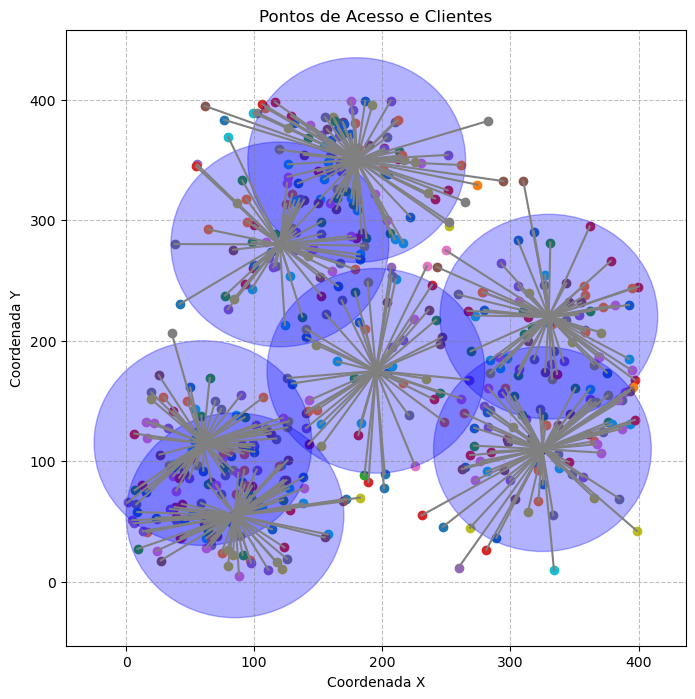

CLIENTES CONECTADOS 495.0
CLIENTES SEM CONEXÃO 0.0


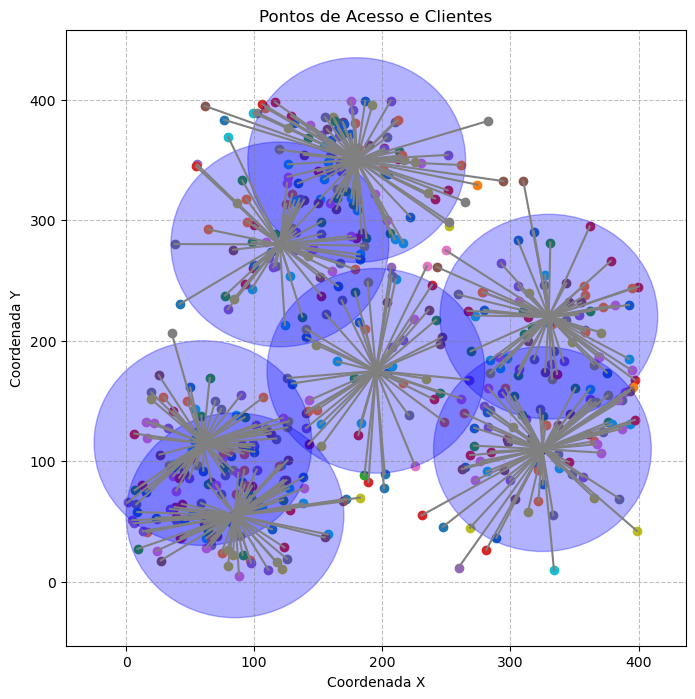

CLIENTES CONECTADOS 495.0
CLIENTES SEM CONEXÃO 0.0


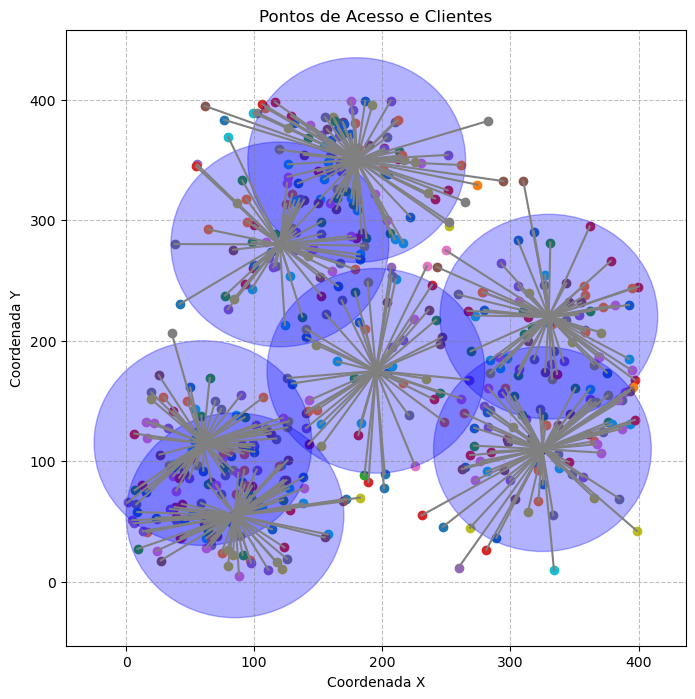

CLIENTES CONECTADOS 495.0
CLIENTES SEM CONEXÃO 0.0


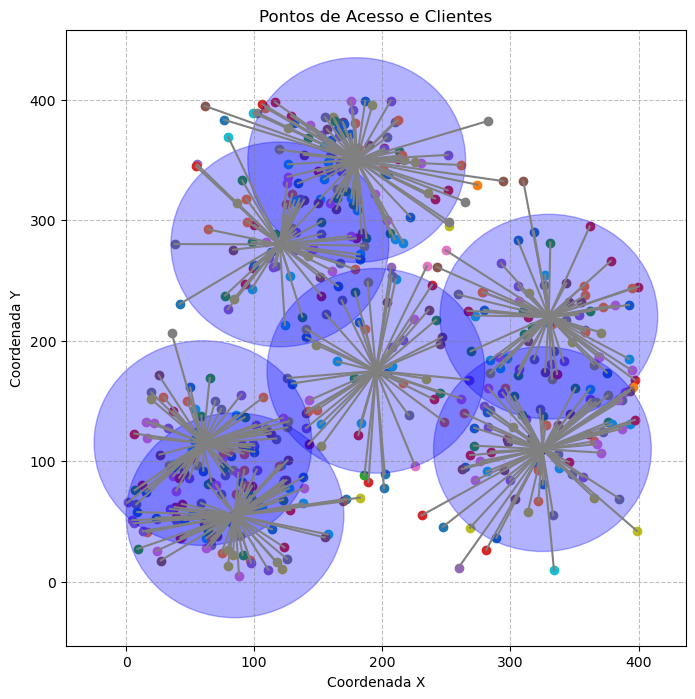

In [452]:
# Graficos para visualização das soluções

import matplotlib.pyplot as plt
import random


# Função para plotar os PAs e os clientes em um grid
def plot_progress(progress, i):
    # Criar uma nova figura
    plt.figure(figsize=(12, 5))

    # Plotar resultados
    for i in range(i):
      plt.plot(progress[0]['fitness'], label='Fitness 1')
      plt.plot(progress[1]['fitness'], label='Fitness 2')
      plt.plot(progress[2]['fitness'], label='Fitness 3')
      plt.plot(progress[3]['fitness'], label='Fitness 4')
      plt.plot(progress[4]['fitness'], label='Fitness 5')
      # plt.scatter(client_coordinates[:, 0], client_coordinates[:, 1], marker='o', color='blue', label='Clientes')

    # Adicionar legendas e título
    plt.xlabel('Iterações')
    plt.ylabel('Numero de PAs')
    plt.title('Convergência das soluções')
    #plt.legend()

    # Mostrar o gráfico
    plt.show()

def cor_vibrante():
    # Gerar valores RGB mais vibrantes
    r = random.randint(180, 255)  # Valor de vermelho entre 180 e 255
    g = random.randint(0, 255)    # Valor de verde entre 0 e 255
    b = random.randint(0, 255)    # Valor de azul entre 0 e 255

    # Converter para formato hexadecimal
    cor_hex = "#{:02x}{:02x}{:02x}".format(r, g, b)
    return cor_hex


# Função para plotar os PAs e os clientes em um grid
def plot_solution(solution, client_coordinates):
    # Criar uma nova figura
    plt.figure(figsize=(8, 8))

    # Plotar o grid
    plt.grid(True, linestyle='--', color='gray', alpha=0.5)

    # Definindo as cores RGB para os 30 pontos de acesso
    cores_acesso = [cor_vibrante() for _ in range(30)]

    # Plotar os PAs
    pa_coordinates = solution['pa_coordinates']
    posicao_cliente = solution['client_coordinates']

    tot = 0
    sem = 0
    for i in range(num_pa_locations):
      if solution['y'][i] == 1:
        tot += np.sum(solution['x'][i])
      else:
         sem += np.sum(solution['x'][i])

    print("CLIENTES CONECTADOS", tot)
    print("CLIENTES SEM CONEXÃO", sem)

    # Plotar os clientes
    for i in range(num_pa_locations):
      if solution['y'][i] == 1:
        plt.scatter(pa_coordinates[i, 0], pa_coordinates[i, 1], marker='s', c='black', label='Pontos de Acesso')        
        for j in range(num_clients):
          if solution['x'][i, j] == 1:
            plt.scatter(posicao_cliente[j, 0], posicao_cliente[j, 1], marker='o', label='Clientes')
            plt.plot([pa_coordinates[i, 0], posicao_cliente[j, 0]], [pa_coordinates[i, 1], posicao_cliente[j, 1]], 'gray')

    # Definir o raio do círculo
    raio_circulo = pa_coverage

    # Plotar círculos ao redor dos pontos de acesso
    for i in range(num_pa_locations):
      if solution['y'][i] == 1:
          pa_x = pa_coordinates[i, 0]
          pa_y = pa_coordinates[i, 1]
          circulo = plt.Circle((pa_x, pa_y), raio_circulo, color='blue', alpha=0.3)
          plt.gca().add_patch(circulo)

    # Adicionar legendas e título
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title('Pontos de Acesso e Clientes')


    #plt.legend()

    # Mostrar o gráfico
    plt.show()

# Plotar curva de convergencia
#plot_progress(progress,1000)


# Carrega os dados dos clientes do arquivo CSV
clients_data = get_clients()

# Extrai as coordenadas dos clientes do array
client_coordinates = clients_data[:, :2]

# Plotar a solução da função objetivo 1
for i in range(5):
   plot_solution(best_solution[i], client_coordinates)

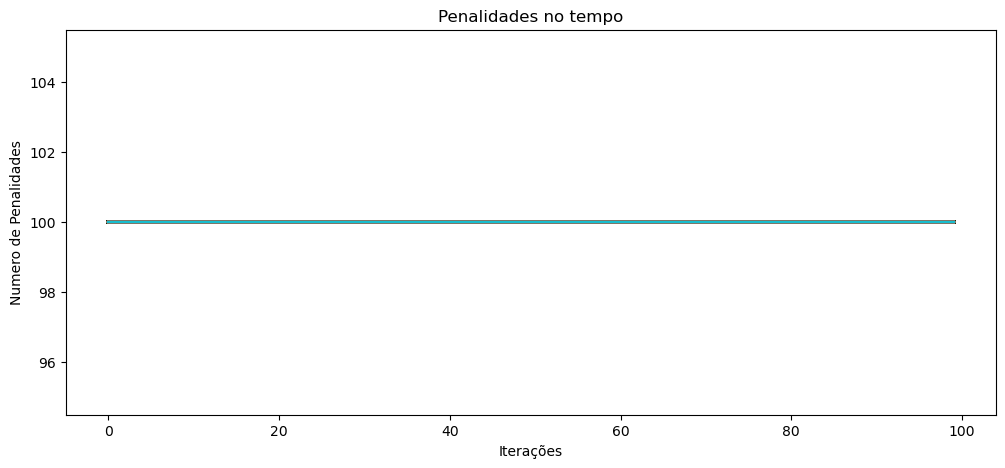

In [453]:
# Função para plotar os PAs e os clientes em um grid
def plot_progress(progress, i):
    # Criar uma nova figura
    plt.figure(figsize=(12, 5))

    # Plotar resultados
    for i in range(i):
      plt.plot(progress[0]['penalty'], label='Penalidade 1')
      plt.plot(progress[1]['penalty'], label='Penalidade 2')
      plt.plot(progress[2]['penalty'], label='Penalidade 3')
      plt.plot(progress[3]['penalty'], label='Penalidade 4')
      plt.plot(progress[4]['penalty'], label='Penalidade 5')
      # plt.scatter(client_coordinates[:, 0], client_coordinates[:, 1], marker='o', color='blue', label='Clientes')

    # Adicionar legendas e título
    plt.xlabel('Iterações')
    plt.ylabel('Numero de Penalidades')
    plt.title('Penalidades no tempo')
    #plt.legend()

    # Mostrar o gráfico
    plt.show()



# Plotar curva de penalidade
plot_progress(progress,1000)
